<a href="https://colab.research.google.com/github/unasthana/ResNet18_CIFAR_10/blob/main/CustomResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training ResNet18 on CIFAR - 10 Dataset**
**-- Ujjwal Asthana, Shivani Singh, Shruti Wagle**

The challenge is to train a ResNet18 model on the CIFAR - 10 dataset such that the number of trainable paramters do not exceed 5 Million. 

## Part - 1: Notebook Imports and Intializations

In [1]:
# Necessary Imports

import os
import random
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

from torchsummary import summary
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

Firstly, we will be defining some constants. Batch size is taken as 128 for both the training and testing set. We will be training the network for 100 epochs on the available GPU system.

In [2]:
# Global Constants

SEED = 42
BATCH_SIZE = 128
EPOCHS = 100
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = "/content/models"

Secondly, in order to make our results reproducible for multiple re-runs, we will be setting seeds for different non-deterministic systems.

In [3]:
# Setting both CPU and GPU seeds for reproducibility

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Part - 2: Data Preprocessing

Now, we will download the CIFAR - 10 dataset and apply the following data augmentations:


*   **Cropping:** This tranformation crops the image at a random location. For eg: transforms.RandomCrop(32, padding = 4) crops a square patch of size 32x32 from an input image with a padding of 4 pixels on all sides. The padding is added to the input image before the random cropping to avoid cropping important parts of the image. This transformation adds diversity to the dataset by adding variations in the position and scale of objects in the image. By randomly cropping different parts of the image, the model learns to recognize objects from different perspectives and positions, leading to better generalization performance.
 
*   **Horizontal Flip:** This transformation horizontally flips an image randomly with a probability of 0.5 (i.e., with a 50% chance). It is important to note that by randomly flipping images horizontally, the model learns to recognize objects regardless of their orientation in the image, leading to better generalization performance.
 
*   **Rotation:** This transformation randomly rotates an image by a maximum angle which is assigned as a paramter either in clockwise or counterclockwise direction. For eg: transforms.RandomRotation(10) randomly rotates the image by a random angle in the range [-10, 10] degrees. It is important to note that by randomly rotating images, the model learns to recognize objects from different orientations and angles, leading to better generalization performance.
 
*   **Normalization:** This transformation normalizes the pixel values of an image. In particular, it subtracts from each pixel value, the mean of each color channel and divides it by its standard deviation. The parameters (0.4914, 0.4822, 0.4465) and (0.2023, 0.1994, 0.2010) are the mean and standard deviation of the three color channels (red, green, and blue) for the CIFAR-10 dataset to which this transformation is applied to. This transformation helps to make the training process more stable and efficient by reducing the impact of differences in lighting conditions and color distributions between images. By normalizing the pixel values of an image, the range of values is typically constrained to a smaller range, typically between -1 and 1, which can make the optimization process easier and can improve the model's accuracy.



In [4]:
# Downloading dataset and performing data augmentations

transform_train = transforms.Compose([transforms.RandomCrop(32, padding = 4), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(10), 
                                      transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                  (0.2023, 0.1994, 0.2010)),])

transform_test = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.4822, 0.4465), 
                                                  (0.2023, 0.1994, 0.2010)),])

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, 
                                        download = True, 
                                        transform = transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, 
                                          shuffle = True, num_workers = 2, 
                                        worker_init_fn = np.random.seed(SEED))

testset = torchvision.datasets.CIFAR10(root = './data', train = False, 
                                       download = True, 
                                       transform = transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, 
                                         shuffle = False, num_workers = 2, 
                                         worker_init_fn = np.random.seed(SEED))

100%|██████████| 170498071/170498071 [00:05<00:00, 29261267.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


##Part - 3: ResNet18 Design

Finally, let us now start designing the Residual Block for our ResNet18 network. 

A Residual Block is a structure which is designed to help with the problem of vanishing gradients, which can occur when the gradients become too small to be useful for learning. This problem is particularly pronounced in deep networks that has many layers.

The Residual Block works by adding a "shortcut connection" around one or more layers in the block. The shortcut connection adds the input to the output of the block, so that the final output is the sum of the input and the output of the block. This allows the gradient to flow through the shortcut connection, bypassing some of the layers in the block and helping to mitigate the vanishing gradient problem.

The Residual Block for our ResNet model takes as input the number of input channels, the number of output channels, and a boolean value indicating whether the block should downsample the input (i.e., reduce the spatial resolution of the input) or not.

If the block is downsampling, it uses a convolutional layer with a stride of 2 to reduce the spatial resolution of the input. It also uses a "shortcut" convolutional layer with a stride of 2 to match the spatial resolution of the input and the output channels.

If the block is not downsampling, it uses a convolutional layer with a stride of 1 to preserve the spatial resolution of the input. It does not use a shortcut convolutional layer.

Both versions of the block then apply batch normalization and ReLU activation functions to the output of the convolutional layers, and then add the shortcut connection to the output. The final output of the block is the ReLU activation of the sum of the input and output.

In [5]:
# Designing Residual Block for the ResNet18

class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels, downsample):

        super().__init__()
        
        if downsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                                   stride = 2, padding = 1)
            
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels,
                                                    kernel_size = 1, 
                                                    stride = 2), 
                                          nn.BatchNorm2d(out_channels))
        
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                                   stride = 1, padding = 1)
            
            self.shortcut = nn.Sequential()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1)
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    
    def forward(self, input):

        shortcut = self.shortcut(input)
        input = self.conv1(input)
        input = self.bn1(input)
        input = nn.ReLU()(input)
        input = self.conv2(input)
        input = self.bn2(input)

        input = input + shortcut
        output = nn.ReLU()(input)

        return output

Now, let us design the ResNet18 architecture.

This network takes in three arguments: 'in_channels' which represents the number of input channels, 'resblock' which is the ResBlock class defined earlier, and outputs which represents the number of output classes (10 for CIFAR - 10).

The ResNet18 architecture begins with a 'layer0' which is a sequence of convolutional, batch normalization, and ReLU layers. 'layer0' takes the input image and applies a convolutional operation with a kernel size of 3, followed by batch normalization and ReLU activation. This operation is designed to extract low-level features from the input image.

The architecture then continues with a series of four ResBlock layers ('layer1' through 'layer4'). Each ResBlock layer consists of multiple ResBlocks stacked together, and each ResBlock layer has a different number of output channels and downsampling settings. The downsample argument in the ResBlock class determines whether or not the shortcut connection should perform downsampling or not.

After the four ResBlock layers, the architecture applies an average pooling operation with a kernel size of 4, followed by flattening the output and passing it through a fully connected layer with outputs number of units. The output of this fully connected layer represents the final classification result.

In conclusion, it is designed to enable the training of very deep neural networks by introducing skip connections between the layers, which allow for the training of much deeper networks than was previously possible.

In [6]:
# Designing ResNet18 from Residual Blocks

class ResNet18(nn.Module):

    def __init__(self, in_channels, resblock, outputs = 10):

        super().__init__()
        
        self.layer0 = nn.Sequential(nn.Conv2d(3, 42, kernel_size = 3, 
                                              stride = 1, padding = 1), 
                                    nn.BatchNorm2d(42), nn.ReLU())

        self.layer1 = nn.Sequential(
            resblock(42, 42, downsample = False),
            resblock(42, 42, downsample = False)
        )

        self.layer2 = nn.Sequential(
            resblock(42, 84, downsample = True),
            resblock(84, 84, downsample = False)
        )

        self.layer3 = nn.Sequential(
            resblock(84, 168, downsample = True),
            resblock(168, 168, downsample = False)
        )

        self.layer4 = nn.Sequential(
            resblock(168, 336, downsample = True),
            resblock(336, 336, downsample = False)
        )

        self.fc = torch.nn.Linear(336, outputs)

    def forward(self, input):
        
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)

        input = F.avg_pool2d(input, 4)
        input = input.view(input.size(0), -1)
        output = self.fc(input)

        return output

Now, let us define a function to initialize the network according to our needs. We will be using cross-entropy loss here.

Cross-entropy loss is a good choice here as it has a very desirable property of being able to penalize incorrect confident predictions. In other words, if the model is very confident about a wrong prediction, the cross-entropy loss will be high and the model will be penalized more heavily for that error. This property is especially important for multi-class classification tasks, where the model has to choose between several different classes, as it encourages the model to produce a more accurate probability distribution over the classes.

In [7]:
# Defining function to initialize the neural network

def initNetwork():

    global criterion

    criterion = nn.CrossEntropyLoss()
    net = ResNet18(3, ResBlock, outputs = 10)
    net.to(DEVICE) 

    return net

Next, we define the function that trains our ResNet.

In [8]:
# Defining the train function

train_accs = []
train_losses = [] 


def train(epoch):

    print('\nEpoch: %d' % (epoch + 1))
    net.train()

    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_acc = correct * 100 / total
    train_loss = train_loss / len(trainloader)

    train_accs.append(train_acc)
    train_losses.append(train_loss)

    print("Train Loss = " + str(train_loss) + "\t \t" + "Train Accuracy = " +
          str(correct) + "/" + str(total) + " = " + str(train_acc))

Next, we define the function that tests our ResNet every epoch on the test dataset.

In [9]:
# Defining the test function

test_accs = []
test_losses = []

def test(epoch):

    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):

            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100. * correct / total
    test_loss = test_loss / len(testloader)

    test_accs.append(acc)
    test_losses.append(test_loss)

    print("Test Loss = " + str(test_loss) + "\t \t" + "Test accuracy = " + 
          str(correct) + "/" + str(total)+" = " + str(acc))
    
    return acc

Next, we define the function that plots the training/testing accuracies as well as the training/testing losses over the course of the entire training process.

In [10]:
# Plotting Losses and Accuracies

def plot_metrics(train_accs, test_accs, train_losses, test_losses, epoch, 
                 value):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

    ax1.plot(range(EPOCHS), train_losses, '-', linewidth = '3', 
             label = 'Train Error')
    
    ax1.plot(range(EPOCHS), test_losses, '-', linewidth = '3', 
             label = 'Test Error')
    
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss Vs Epoch")

    ax2.plot(range(EPOCHS), train_accs, '-', linewidth = '3', 
             label = 'Train Accuracy')
    
    ax2.plot(range(EPOCHS), test_accs, '-', linewidth = '3', 
             label = 'Test Acuracy')
    
    ax2.annotate("Max Accuracy = " + str(value), xy = (epoch, value), 
                 xytext = (epoch + 5, value + 5), 
                 arrowprops  = dict(facecolor = 'black', shrink = 0.05))
    
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Accuracy Vs Epoch")

    ax1.grid(True)
    ax2.grid(True)
    ax1.legend()
    ax2.legend()   

Now, let us check whether our model is in budget or not.

In [11]:
# Defining model and printing summary

net = ResNet18(3, ResBlock, outputs = 10)
net.to(DEVICE)
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 42, 32, 32]           1,176
       BatchNorm2d-2           [-1, 42, 32, 32]              84
              ReLU-3           [-1, 42, 32, 32]               0
            Conv2d-4           [-1, 42, 32, 32]          15,918
       BatchNorm2d-5           [-1, 42, 32, 32]              84
            Conv2d-6           [-1, 42, 32, 32]          15,918
       BatchNorm2d-7           [-1, 42, 32, 32]              84
          ResBlock-8           [-1, 42, 32, 32]               0
            Conv2d-9           [-1, 42, 32, 32]          15,918
      BatchNorm2d-10           [-1, 42, 32, 32]              84
           Conv2d-11           [-1, 42, 32, 32]          15,918
      BatchNorm2d-12           [-1, 42, 32, 32]              84
         ResBlock-13           [-1, 42, 32, 32]               0
           Conv2d-14           [-1, 84,

We can see from the above output that the number of trainable parameters is around 4.8 Million. Therefore, the model is in budget and we can proceed forward with the training process.

Now, we initialize the ResNet18, select an appropriate optimizer and implement some learning rate decay scheme for our training process.

We use the stochastic gradient descent (SGD) algorithm with some momentum as our optimizer here. The learning rate determines the step size at each iteration of the optimization process. The momentum determines the contribution of the previous update to the current update, helping to accelerate the convergence of the optimization process. Finally, the weight_decay parameter applies L2 regularization to the weights, preventing overfitting and improving the generalization ability of the model.

For our learning rate scheduler, we choose the 'CosineAnnealingLR' function, which gradually reduces the learning rate over the course of training. This is how the learning rate is decided in CosineAnnealingLR:

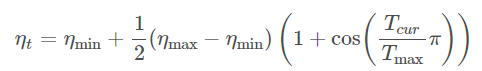

'T_max' : the number of epochs for which the learning rate will be reduced.

'T_cur' : the current epoch

'eta_max' : Maximum Learning Rate

'eta_min' : Minimum Learning Rate

'eta_t' : The learning rate at 'T_cur' (the current learning rate)

By using a learning rate scheduler, the optimization process becomes more stable and efficient, as the learning rate is decreased over time, allowing the model to converge more smoothly.

## Part - 4: Training ResNet18


In our notebook, we stick with a momentum of 0.0005 and a weight_decay of 5e-4 and experiment with 5 different learning rates. 

First, let us create a directory for storing model weights.

In [12]:
# Creating directory to store the model weights for different cases

try: 
    os.mkdir(PATH)

except OSError as error: 
    print(error)

### CASE - 1: lr = 0.1, momentum = 0.0005, weight_decay =  5e-4

In [ ]:
# Initializing network and setting optimizer and Learning Rate Decay (CASE - 1)

net = initNetwork()

optimizer = optim.SGD(net.parameters(), lr = 0.1, momentum = 0.0005, 
                      weight_decay = 5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max = EPOCHS)

In [ ]:
# Training the ResNet18 (CASE - 1)

best_acc = 0

train_accs = []
train_losses = []

test_accs = []
test_losses = []

for epoch in range(EPOCHS):
  
  train(epoch)
  acc = test(epoch)

  if acc > best_acc:
      best_acc = acc
      torch.save(net.state_dict(), '/content/models/resnet1.pt')
  
  print("Best Test Accuracy = " + str(best_acc))
  scheduler.step()  


Epoch: 1
Train Loss = 1.6416010509061691	 	Train Accuracy = 20324/50000 = 40.648
Test Loss = 1.6008662588988678	 	Test accuracy = 4523/10000 = 45.23
Best Test Accuracy = 45.23

Epoch: 2
Train Loss = 1.1221485804109013	 	Train Accuracy = 29799/50000 = 59.598
Test Loss = 1.2158742577214785	 	Test accuracy = 5905/10000 = 59.05
Best Test Accuracy = 59.05

Epoch: 3
Train Loss = 0.8877209277104234	 	Train Accuracy = 34185/50000 = 68.37
Test Loss = 1.125676465939872	 	Test accuracy = 6390/10000 = 63.9
Best Test Accuracy = 63.9

Epoch: 4
Train Loss = 0.743359031732125	 	Train Accuracy = 37000/50000 = 74.0
Test Loss = 1.1285072036936312	 	Test accuracy = 6549/10000 = 65.49
Best Test Accuracy = 65.49

Epoch: 5
Train Loss = 0.6633771628979832	 	Train Accuracy = 38444/50000 = 76.888
Test Loss = 0.6559318439869941	 	Test accuracy = 7747/10000 = 77.47
Best Test Accuracy = 77.47

Epoch: 6
Train Loss = 0.5965125280268052	 	Train Accuracy = 39495/50000 = 78.99
Test Loss = 0.7203664157209517	 	Test acc

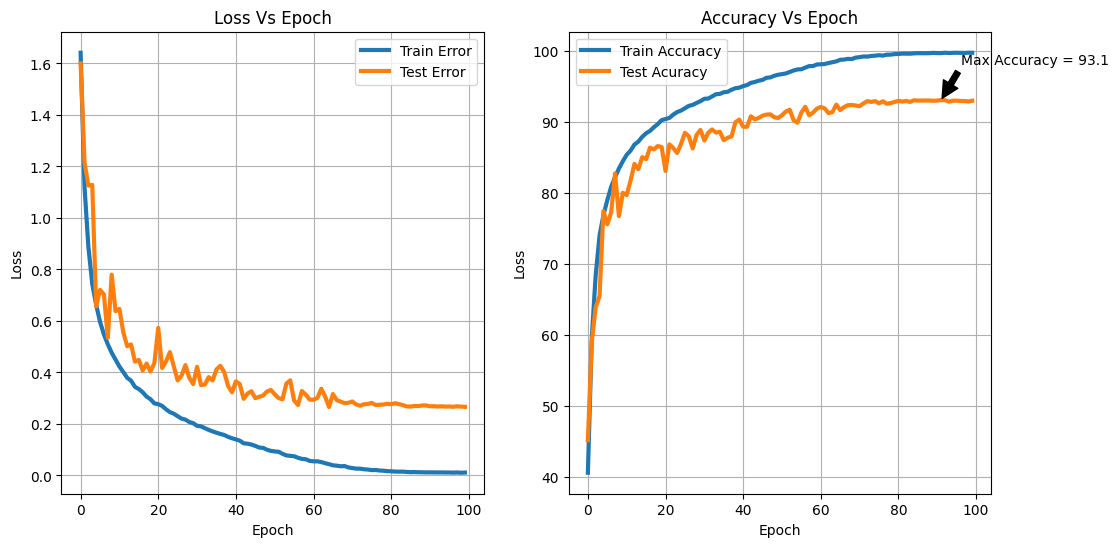

In [ ]:
# Plotting Losses and Accuracies for the training process (CASE - 1)

plot_metrics(train_accs, test_accs, train_losses, test_losses, 
             max(range(len(test_accs)), key = test_accs.__getitem__), 
             max(test_accs))

### CASE - 2: lr = 0.05, momentum = 0.0005, weight_decay = 5e-4

In [ ]:
# Initializing network and setting optimizer and Learning Rate Decay (CASE - 2)

net = initNetwork()

optimizer = optim.SGD(net.parameters(), lr = 0.05, momentum = 0.0005, 
                      weight_decay = 5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max = EPOCHS)

In [ ]:
# Training the ResNet18 (CASE - 2)

best_acc = 0

train_accs = []
train_losses = []

test_accs = []
test_losses = []

for epoch in range(EPOCHS):
  
  train(epoch)
  acc = test(epoch)

  if acc > best_acc:
      best_acc = acc
      torch.save(net.state_dict(), '/content/models/resnet2.pt')
  
  print("Best Test Accuracy = " + str(best_acc))
  scheduler.step()  


Epoch: 1
Train Loss = 1.5489020981752049	 	Train Accuracy = 21338/50000 = 42.676
Test Loss = 1.4036755667457097	 	Test accuracy = 5178/10000 = 51.78
Best Test Accuracy = 51.78

Epoch: 2
Train Loss = 1.0958510176909855	 	Train Accuracy = 30296/50000 = 60.592
Test Loss = 1.1542768553842473	 	Test accuracy = 6135/10000 = 61.35
Best Test Accuracy = 61.35

Epoch: 3
Train Loss = 0.8836244856914901	 	Train Accuracy = 34232/50000 = 68.464
Test Loss = 0.8426478557948824	 	Test accuracy = 7128/10000 = 71.28
Best Test Accuracy = 71.28

Epoch: 4
Train Loss = 0.7580054021247512	 	Train Accuracy = 36574/50000 = 73.148
Test Loss = 1.1161629331262806	 	Test accuracy = 6718/10000 = 67.18
Best Test Accuracy = 71.28

Epoch: 5
Train Loss = 0.6712470659057198	 	Train Accuracy = 38261/50000 = 76.522
Test Loss = 0.7567005278188971	 	Test accuracy = 7434/10000 = 74.34
Best Test Accuracy = 74.34

Epoch: 6
Train Loss = 0.6187855259079458	 	Train Accuracy = 39173/50000 = 78.346
Test Loss = 0.8228655178335649	 	

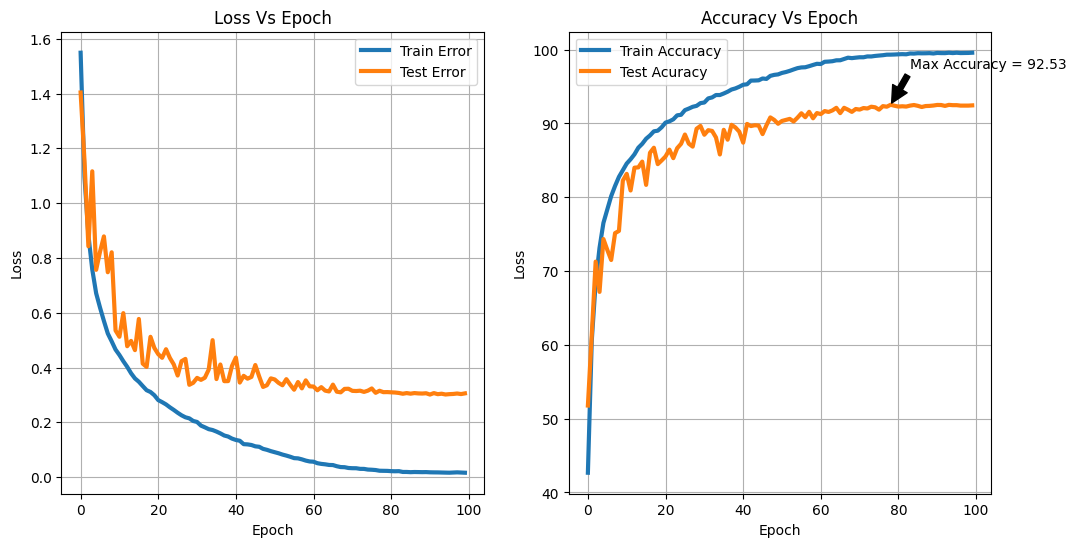

In [ ]:
# Plotting Losses and Accuracies for the training process (CASE - 2)

plot_metrics(train_accs, test_accs, train_losses, test_losses, 
             max(range(len(test_accs)), key = test_accs.__getitem__), 
             max(test_accs))

### CASE - 3: lr = 0.15, momentum = 0.0005, weight_decay = 5e-4

In [13]:
# Initializing network and setting optimizer and Learning Rate Decay (CASE - 3)

net = initNetwork()

optimizer = optim.SGD(net.parameters(), lr = 0.15, momentum = 0.0005, 
                      weight_decay = 5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max = EPOCHS)

In [14]:
# Training the ResNet18 (CASE - 3)

best_acc = 0

train_accs = []
train_losses = []

test_accs = []
test_losses = []

for epoch in range(EPOCHS):
  
  train(epoch)
  acc = test(epoch)

  if acc > best_acc:
      best_acc = acc
      torch.save(net.state_dict(), '/content/models/resnet3.pt')
  
  print("Best Test Accuracy = " + str(best_acc))
  scheduler.step()  


Epoch: 1
Train Loss = 1.735129335652227	 	Train Accuracy = 17902/50000 = 35.804
Test Loss = 1.61283049100562	 	Test accuracy = 4375/10000 = 43.75
Best Test Accuracy = 43.75

Epoch: 2
Train Loss = 1.2560747389293387	 	Train Accuracy = 27060/50000 = 54.12
Test Loss = 1.4013183245176002	 	Test accuracy = 5453/10000 = 54.53
Best Test Accuracy = 54.53

Epoch: 3
Train Loss = 0.975421018002893	 	Train Accuracy = 32606/50000 = 65.212
Test Loss = 1.4055122393596022	 	Test accuracy = 5627/10000 = 56.27
Best Test Accuracy = 56.27

Epoch: 4
Train Loss = 0.804143601061438	 	Train Accuracy = 35776/50000 = 71.552
Test Loss = 0.9036032459403895	 	Test accuracy = 7017/10000 = 70.17
Best Test Accuracy = 70.17

Epoch: 5
Train Loss = 0.6985196301241969	 	Train Accuracy = 37823/50000 = 75.646
Test Loss = 1.1389233726489394	 	Test accuracy = 6577/10000 = 65.77
Best Test Accuracy = 70.17

Epoch: 6
Train Loss = 0.6263956990083466	 	Train Accuracy = 39045/50000 = 78.09
Test Loss = 0.6416437029838562	 	Test ac

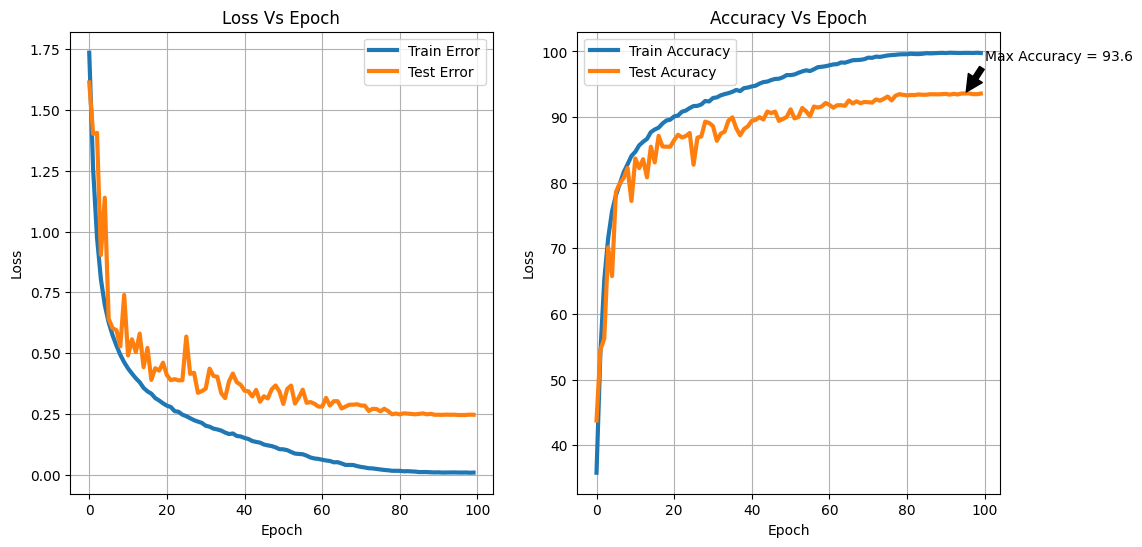

In [15]:
# Plotting Losses and Accuracies for the training process (CASE - 3)

plot_metrics(train_accs, test_accs, train_losses, test_losses, 
             max(range(len(test_accs)), key = test_accs.__getitem__), 
             max(test_accs))

### CASE - 4: lr = 0.2, momentum = 0.0005, weight_decay = 5e-4

In [16]:
# Initializing network and setting optimizer and Learning Rate Decay (CASE - 4)

net = initNetwork()

optimizer = optim.SGD(net.parameters(), lr = 0.2, momentum = 0.0005, 
                      weight_decay = 5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max = EPOCHS)

In [17]:
# Training the ResNet18 (CASE - 4)

best_acc = 0

train_accs = []
train_losses = []

test_accs = []
test_losses = []

for epoch in range(EPOCHS):
  
  train(epoch)
  acc = test(epoch)

  if acc > best_acc:
      best_acc = acc
      torch.save(net.state_dict(), '/content/models/resnet4.pt')
  
  print("Best Test Accuracy = " + str(best_acc))
  scheduler.step()


Epoch: 1
Train Loss = 1.7404510355971354	 	Train Accuracy = 18318/50000 = 36.636
Test Loss = 1.5625590251970896	 	Test accuracy = 4401/10000 = 44.01
Best Test Accuracy = 44.01

Epoch: 2
Train Loss = 1.2534470260905488	 	Train Accuracy = 27087/50000 = 54.174
Test Loss = 1.1709950641740727	 	Test accuracy = 5860/10000 = 58.6
Best Test Accuracy = 58.6

Epoch: 3
Train Loss = 1.0012420751249698	 	Train Accuracy = 32166/50000 = 64.332
Test Loss = 1.0181200202507308	 	Test accuracy = 6454/10000 = 64.54
Best Test Accuracy = 64.54

Epoch: 4
Train Loss = 0.8237095049884923	 	Train Accuracy = 35570/50000 = 71.14
Test Loss = 1.1698696734030036	 	Test accuracy = 6261/10000 = 62.61
Best Test Accuracy = 64.54

Epoch: 5
Train Loss = 0.7221118913739538	 	Train Accuracy = 37317/50000 = 74.634
Test Loss = 0.9454840806466115	 	Test accuracy = 6876/10000 = 68.76
Best Test Accuracy = 68.76

Epoch: 6
Train Loss = 0.6470671657406156	 	Train Accuracy = 38669/50000 = 77.338
Test Loss = 1.0016561542885214	 	Tes

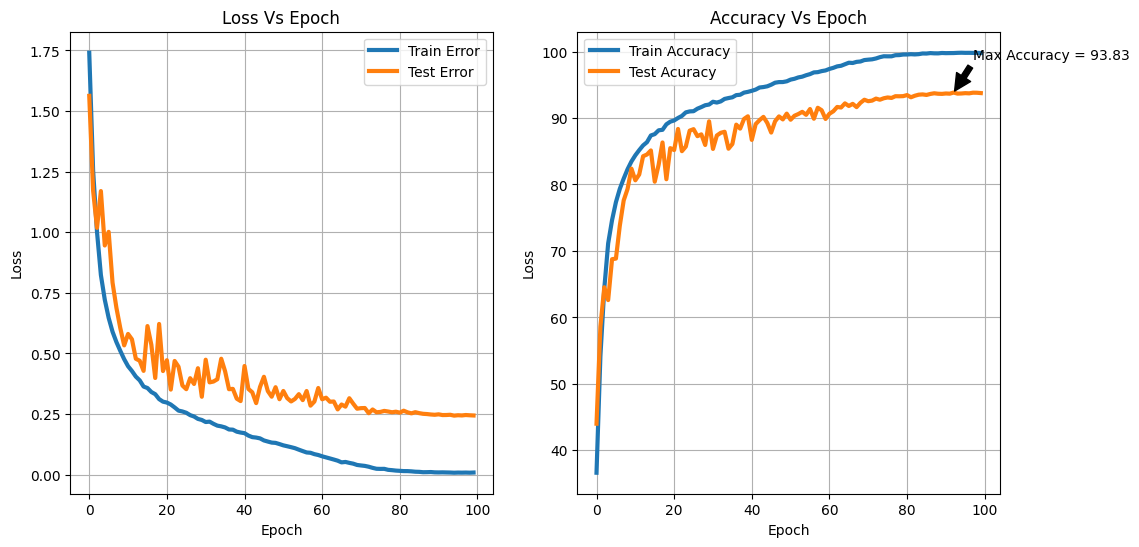

In [19]:
# Plotting Losses and Accuracies for the training process (CASE - 4)

plot_metrics(train_accs, test_accs, train_losses, test_losses, 
             max(range(len(test_accs)), key = test_accs.__getitem__), 
             max(test_accs))

### CASE - 5: lr = 0.25, momentum = 0.0005, weight_decay = 5e-4

In [23]:
# Initializing network and setting optimizer and Learning Rate Decay (CASE - 5)

net = initNetwork()

optimizer = optim.SGD(net.parameters(), lr = 0.25, momentum = 0.0005, 
                      weight_decay = 5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max = EPOCHS)

In [24]:
# Training the ResNet18 (CASE - 5)

best_acc = 0

train_accs = []
train_losses = []

test_accs = []
test_losses = []

for epoch in range(EPOCHS):
  
  train(epoch)
  acc = test(epoch)

  if acc > best_acc:
      best_acc = acc
      torch.save(net.state_dict(), '/content/models/resnet5.pt')
  
  print("Best Test Accuracy = " + str(best_acc))
  scheduler.step()


Epoch: 1
Train Loss = 1.7762929457227896	 	Train Accuracy = 17522/50000 = 35.044
Test Loss = 1.4218803764898567	 	Test accuracy = 4696/10000 = 46.96
Best Test Accuracy = 46.96

Epoch: 2
Train Loss = 1.3141881072002908	 	Train Accuracy = 26129/50000 = 52.258
Test Loss = 1.340556419348415	 	Test accuracy = 5318/10000 = 53.18
Best Test Accuracy = 53.18

Epoch: 3
Train Loss = 1.0740064275844017	 	Train Accuracy = 30906/50000 = 61.812
Test Loss = 1.3038390301450897	 	Test accuracy = 5532/10000 = 55.32
Best Test Accuracy = 55.32

Epoch: 4
Train Loss = 0.9121607503927577	 	Train Accuracy = 33849/50000 = 67.698
Test Loss = 1.0490855385985556	 	Test accuracy = 6381/10000 = 63.81
Best Test Accuracy = 63.81

Epoch: 5
Train Loss = 0.79408175827902	 	Train Accuracy = 36042/50000 = 72.084
Test Loss = 0.8338470149643814	 	Test accuracy = 7168/10000 = 71.68
Best Test Accuracy = 71.68

Epoch: 6
Train Loss = 0.7009452057768927	 	Train Accuracy = 37777/50000 = 75.554
Test Loss = 1.011058439936819	 	Test

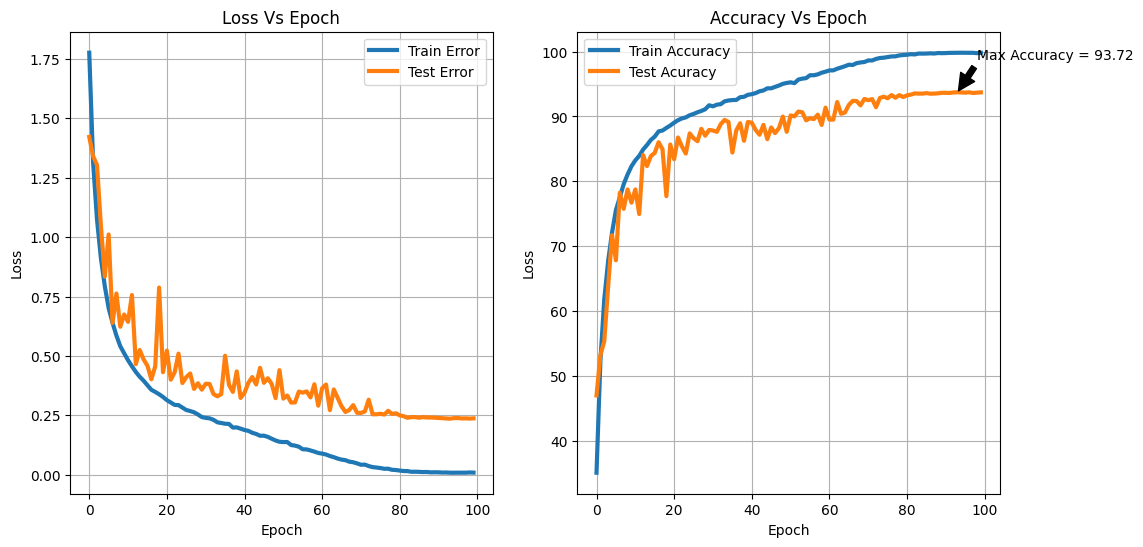

In [25]:
# Plotting Losses and Accuracies for the training process (CASE - 5)

plot_metrics(train_accs, test_accs, train_losses, test_losses, 
             max(range(len(test_accs)), key = test_accs.__getitem__), 
             max(test_accs))

## Part - 5: Testing ResNet18

From the results in Part - 4, it is evident that the ResNet trained in **Case - 4** is performing the best as it has the maximum test accuracy of **93.83%**. Hence, we are going to load that model and compute different performace metrics.

In [26]:
# Loading model from the system and evaluating on the testing set

net = initNetwork()
net.load_state_dict(torch.load('/content/models/resnet4.pt'))

net.eval()
correct = 0
total = 0

predictions = []
labels = []

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        predictions.extend(predicted.cpu())
        labels.extend(targets.cpu())

accuracy = 100. * correct / total
print("The Best Test Accuracy achieved is: " + str(accuracy))

The Best Test Accuracy achieved is: 93.83


Now, we look at other performance metrics such as precision, recall and F-1 score.

**Precision:** is the proportion of true positives among all the positive predictions. It measures how well the model identifies positive samples correctly.

**Recall:** also known as sensitivity or true positive rate, is the proportion of true positives among all the actual positive samples. It measures how well the model captures positive samples. 

**F1 score:** is the harmonic mean of precision and recall. It balances both precision and recall and provides a single score to evaluate the model's performance.

In [27]:
# Printing Classification Report

print(classification_report(labels, predictions, 
                            target_names = testset.classes))

              precision    recall  f1-score   support

    airplane       0.94      0.95      0.94      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.92      0.91      0.92      1000
         cat       0.87      0.87      0.87      1000
        deer       0.92      0.95      0.94      1000
         dog       0.92      0.90      0.90      1000
        frog       0.95      0.96      0.96      1000
       horse       0.97      0.96      0.96      1000
        ship       0.97      0.96      0.96      1000
       truck       0.95      0.96      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



We got a pretty great weighted **F-1 score** of **0.94.**

Now, let us find out what classes are being misclassified by the network.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

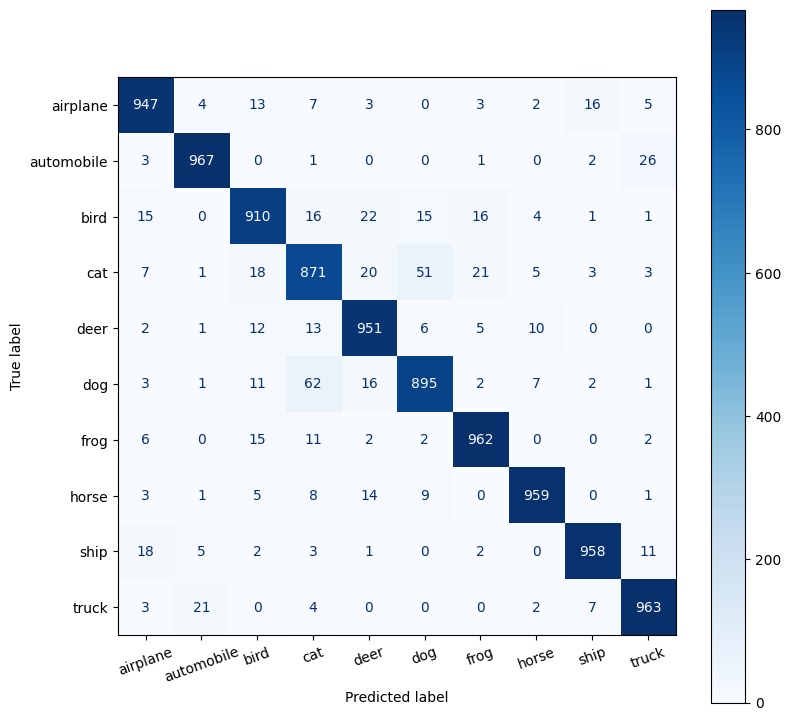

In [28]:
# Plotting Confusion Matrix

fig = plt.figure(figsize = (9, 9));
ax = fig.add_subplot(1, 1, 1);
cm = confusion_matrix(labels, predictions);
cm = ConfusionMatrixDisplay(cm, display_labels = testset.classes);
cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
plt.xticks(rotation = 20)

The above figure suggests that **'cat'** and **'dog'** is being misclassified the most for each other.